In [31]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import ctypes
import os

# --- Rust FFI Wrapper ---

# Load Rust Library (FFI)
# Try relative path assuming notebook is in root
dll_path = os.path.join("RustLib", "target", "release", "rust_machine_learning_library.dll")

if not os.path.exists(dll_path):
    # Fallback to absolute path search if needed, or just print warning
    print(f"Warning: {dll_path} not found. Checking current directory: {os.getcwd()}")

try:
    lib = ctypes.CDLL(dll_path)
except OSError:
    # If standard path fails, try finding it relative to this notebook file if possible, 
    # but for now we assume CWD is correct or user fixes path.
    # We can try to be robust:
    base_dir = r"f:\Projets\PaddleCatcher"
    dll_path = os.path.join(base_dir, "RustLib", "target", "release", "rust_machine_learning_library.dll")
    lib = ctypes.CDLL(dll_path)

# --- Perceptron FFI ---
lib.perceptron_new.argtypes = [ctypes.c_int, ctypes.c_float, ctypes.c_bool]
lib.perceptron_new.restype = ctypes.c_void_p

lib.perceptron_predict.argtypes = [ctypes.c_void_p, ctypes.POINTER(ctypes.c_float), ctypes.c_int]
lib.perceptron_predict.restype = ctypes.c_float

lib.perceptron_train.argtypes = [ctypes.c_void_p, ctypes.POINTER(ctypes.c_float), ctypes.c_int, ctypes.c_float]
lib.perceptron_train.restype = None

lib.perceptron_free.argtypes = [ctypes.c_void_p]
lib.perceptron_free.restype = None

# --- MLP FFI ---
lib.mlp_new.argtypes = [ctypes.POINTER(ctypes.c_size_t), ctypes.c_size_t]
lib.mlp_new.restype = ctypes.c_void_p

lib.mlp_predict.argtypes = [
    ctypes.c_void_p, 
    ctypes.POINTER(ctypes.c_float), ctypes.c_int, 
    ctypes.c_bool, 
    ctypes.POINTER(ctypes.c_float), ctypes.c_int
]
lib.mlp_predict.restype = None

lib.mlp_train.argtypes = [
    ctypes.c_void_p, 
    ctypes.POINTER(ctypes.c_float), ctypes.c_int, 
    ctypes.POINTER(ctypes.c_float), ctypes.c_int, 
    ctypes.c_bool, 
    ctypes.c_float
]
lib.mlp_train.restype = None

lib.mlp_free.argtypes = [ctypes.c_void_p]
lib.mlp_free.restype = None


class Perceptron:
    def __init__(self, input_size, learning_rate=0.01, is_classification=True):
        self.model = lib.perceptron_new(input_size, learning_rate, is_classification)
        self.is_classification = is_classification

    def train_py(self, inputs, expected):
        # inputs: list or np.array
        # expected: float
        if isinstance(inputs, list):
            inputs = np.array(inputs, dtype=np.float32)
        
        c_inputs = inputs.ctypes.data_as(ctypes.POINTER(ctypes.c_float))
        c_len = len(inputs)
        lib.perceptron_train(self.model, c_inputs, c_len, float(expected))

    def predict_py(self, inputs):
        if isinstance(inputs, list):
            inputs = np.array(inputs, dtype=np.float32)
            
        c_inputs = inputs.ctypes.data_as(ctypes.POINTER(ctypes.c_float))
        c_len = len(inputs)
        return lib.perceptron_predict(self.model, c_inputs, c_len)

    def __del__(self):
        if hasattr(self, 'model') and self.model:
            lib.perceptron_free(self.model)
            self.model = None


class MLP:
    def __init__(self, layers):
        # layers: list of ints, e.g. [2, 3, 1]
        c_layers_array = np.array(layers, dtype=np.uint64)
        c_layers = c_layers_array.ctypes.data_as(ctypes.POINTER(ctypes.c_size_t))
        self.model = lib.mlp_new(c_layers, len(layers))
        self.layers = layers

    def train_py(self, inputs, outputs, is_classification, num_iter=1000, alpha=0.01):
        # inputs: list of lists or 2D np.array
        # outputs: list of lists or 2D np.array
        
        X = np.array(inputs, dtype=np.float32)
        y = np.array(outputs, dtype=np.float32)
        
        for _ in range(num_iter):
            # Stochastic Gradient Descent
            idx = np.random.randint(0, len(X))
            sample_x = X[idx]
            sample_y = y[idx]
            
            c_input = sample_x.ctypes.data_as(ctypes.POINTER(ctypes.c_float))
            c_input_len = len(sample_x)
            
            c_expected = sample_y.ctypes.data_as(ctypes.POINTER(ctypes.c_float))
            c_expected_len = len(sample_y)
            
            lib.mlp_train(self.model, c_input, c_input_len, c_expected, c_expected_len, is_classification, alpha)

    def predict_py(self, inputs, is_classification):
        # inputs: list or 1D np.array
        if isinstance(inputs, list):
            inputs = np.array(inputs, dtype=np.float32)
            
        c_input = inputs.ctypes.data_as(ctypes.POINTER(ctypes.c_float))
        c_input_len = len(inputs)
        
        output_size = self.layers[-1]
        output_buffer = np.zeros(output_size, dtype=np.float32)
        c_output = output_buffer.ctypes.data_as(ctypes.POINTER(ctypes.c_float))
        
        lib.mlp_predict(self.model, c_input, c_input_len, is_classification, c_output, output_size)
        
        return output_buffer.tolist()

    def __del__(self):
        if hasattr(self, 'model') and self.model:
            lib.mlp_free(self.model)
            self.model = None

# Mocking ml_tower_slots to run existing code without changing calls below
class ml_tower_slots:
    Perceptron = Perceptron
    MLP = MLP


# Cas de tests, rendu 2

## Classification

### Linear Simple :
        Linear Model : OK
        MLP (2, 1)   : OK

In [32]:
X = np.array([
      [1, 1],
      [2, 3],
      [3, 3]
])
Y = np.array([
      1,
      -1,
      -1
])

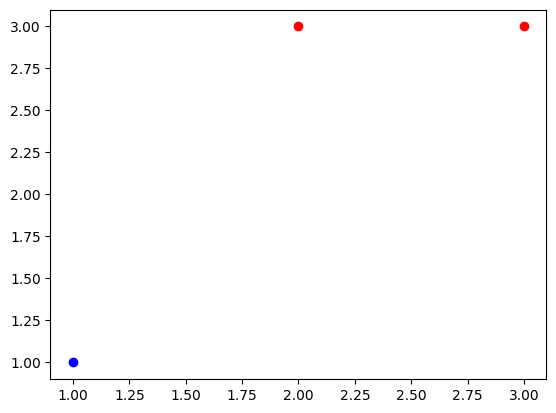

<Figure size 640x480 with 0 Axes>

In [33]:
plt.scatter(X[0, 0], X[0, 1], color='blue')
plt.scatter(X[1:3,0], X[1:3,1], color='red')
plt.show()
plt.clf()

Résultat: OK


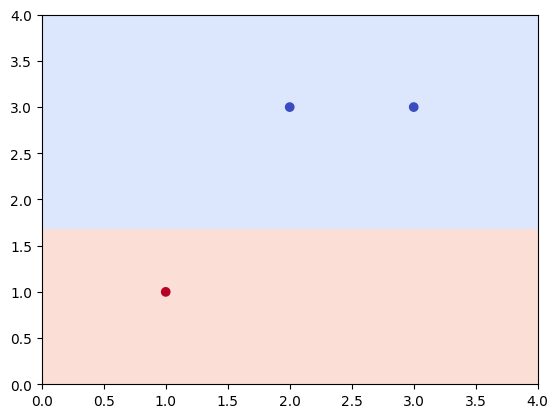

In [34]:
p = ml_tower_slots.Perceptron(2, 0.1, True)

for _ in range(1000): 
    for x, y in zip(X, Y): 
        p.train_py(list(x), float(y)) 
        
# Validation de la séparation 
ok = True 
for x, y in zip(X, Y): 
    pred = p.predict_py(list(x)) 
    if (pred > 0 and y < 0) or (pred < 0 and y > 0): 
        ok = False 

print("Résultat:", "OK" if ok else "KO") 

grid = np.linspace(0, 4, 100) 
xx, yy = np.meshgrid(grid, grid) 

zz = np.array([ p.predict_py([x,y]) for x,y in zip(xx.flatten(), yy.flatten()) ]).reshape(xx.shape) 

plt.contourf(xx, yy, zz, levels=[-1,0,1], alpha=0.3, cmap='coolwarm') 
plt.scatter(X[:,0], X[:,1], c=Y, cmap='coolwarm') 
plt.show()

Résultat MLP : OK


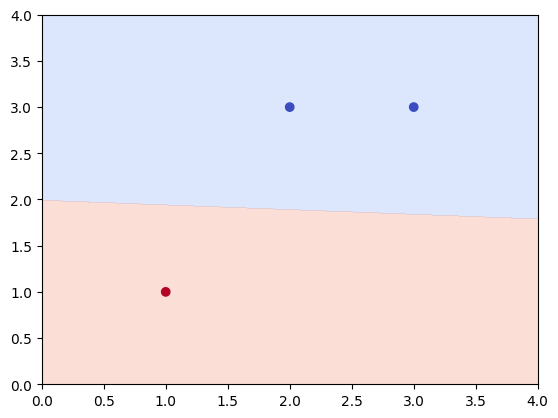

In [35]:
mlp = ml_tower_slots.MLP([2, 1])
inputs = X.tolist()
outputs = Y.reshape(-1,1).tolist()

mlp.train_py(inputs, outputs, True, num_iter=10000, alpha=0.1)

ok = True
for x, y in zip(inputs, outputs):
    pred = mlp.predict_py(x, True)[0]
    if (pred > 0 and y[0] < 0) or (pred < 0 and y[0] > 0):
        ok = False

print("Résultat MLP :", "OK" if ok else "KO")

grid = np.linspace(0, 4, 100)
xx, yy = np.meshgrid(grid, grid)

zz = np.array([
    mlp.predict_py([x, y], True)[0] for x, y in zip(xx.flatten(), yy.flatten())
]).reshape(xx.shape)

plt.contourf(xx, yy, zz, levels=[-1, 0, 1], alpha=0.3, cmap='coolwarm')
plt.scatter(X[:,0], X[:,1], c=Y, cmap='coolwarm')
plt.show()

### Linear Multiple :
        Linear Model : OK
        MLP (2, 1)   : OK

In [36]:
X = np.concatenate([np.random.random((50,2)) * 0.9 + np.array([1, 1]), np.random.random((50,2)) * 0.9 + np.array([2, 2])])
Y = np.concatenate([np.ones((50, 1)), np.ones((50, 1)) * -1.0])

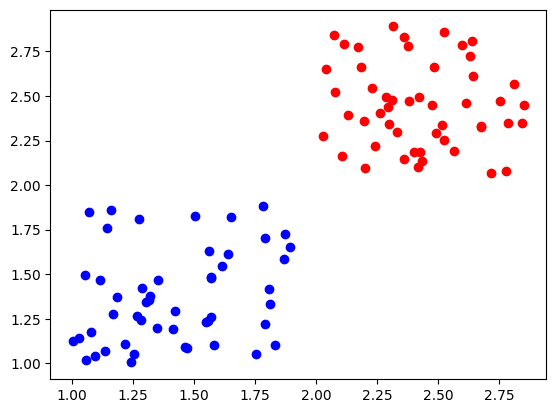

<Figure size 640x480 with 0 Axes>

In [37]:
plt.scatter(X[0:50, 0], X[0:50, 1], color='blue')
plt.scatter(X[50:100,0], X[50:100,1], color='red')
plt.show()
plt.clf()

Perceptron : OK


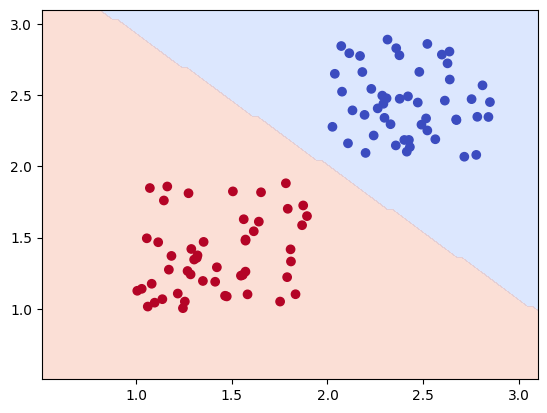

<Figure size 640x480 with 0 Axes>

In [38]:
# --- Perceptron ---
p = ml_tower_slots.Perceptron(2, 0.1, True)
for _ in range(1000):
    for x, y in zip(X, Y):
        p.train_py(list(x), float(y[0]))

# Validation perceptron
ok_p = all((p.predict_py(list(x)) > 0) == (y > 0) for x, y in zip(X, Y))
print("Perceptron :", "OK" if ok_p else "KO")

# Affichage frontiere perceptron
grid = np.linspace(np.min(X[:,0])-0.5, np.max(X[:,0])+0.25, 100)
xx, yy = np.meshgrid(grid, grid)
zz = np.array([p.predict_py([x,y]) for x,y in zip(xx.flatten(), yy.flatten())]).reshape(xx.shape)

plt.contourf(xx, yy, zz, levels=[-1, 0, 1], alpha=0.3, cmap='coolwarm')
plt.scatter(X[:,0], X[:,1], c=Y, cmap='coolwarm')
plt.show()
plt.clf()

MLP : OK


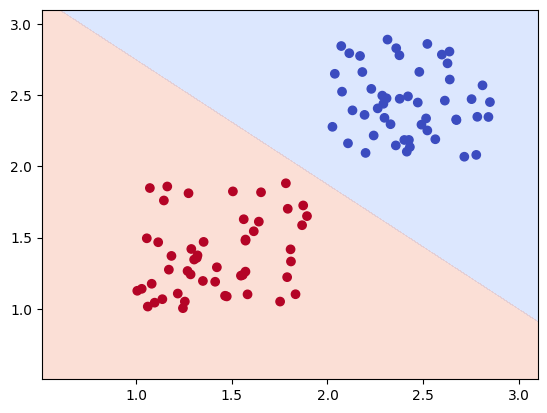

In [39]:
# --- MLP ---
mlp = ml_tower_slots.MLP([2, 2, 1])
inputs = X.tolist()
outputs = Y.reshape(-1, 1).tolist()

mlp.train_py(inputs, outputs, True, num_iter=5000, alpha=0.1)

# Validation MLP
ok_mlp = all(((mlp.predict_py(x, True)[0]) > 0) == (y > 0) for x, y in zip(inputs, Y))
print("MLP :", "OK" if ok_mlp else "KO")

# Affichage frontiere MLP
zz_mlp = np.array([mlp.predict_py([x,y], True)[0] for x,y in zip(xx.flatten(), yy.flatten())]).reshape(xx.shape)

plt.contourf(xx, yy, zz_mlp, levels=[-1, 0, 1], alpha=0.3, cmap='coolwarm')
plt.scatter(X[:,0], X[:,1], c=Y, cmap='coolwarm')
plt.show()

XOR :
        Linear Model    : KO
        MLP (2, 2, 1)   : OK

In [40]:
X = np.array([[1, 0], [0, 1], [0, 0], [1, 1]])
Y = np.array([1, 1, -1, -1])

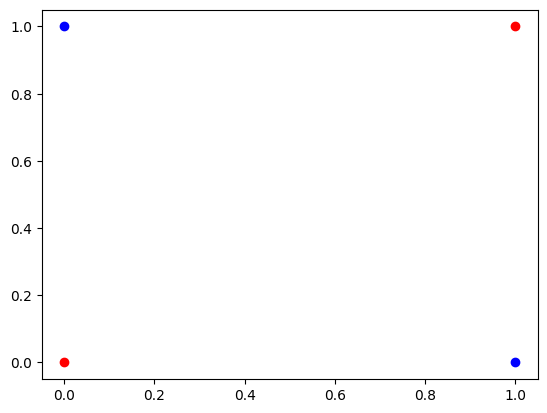

<Figure size 640x480 with 0 Axes>

In [41]:
plt.scatter(X[0:2, 0], X[0:2, 1], color='blue')
plt.scatter(X[2:4,0], X[2:4,1], color='red')
plt.show()
plt.clf()

Perceptron XOR : KO


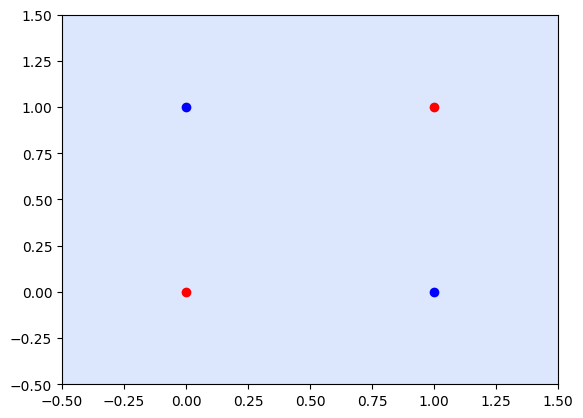

<Figure size 640x480 with 0 Axes>

In [42]:
p = ml_tower_slots.Perceptron(2, 0.1, True)

for _ in range(10000):
    for x, y in zip(X, Y):
        p.train_py(list(x), float(y))

ok_perceptron = all(
    (p.predict_py(list(x)) >= 0 and y > 0) or (p.predict_py(list(x)) < 0 and y < 0)
    for x, y in zip(X, Y)
)
print("Perceptron XOR :", "OK" if ok_perceptron else "KO")

# Affichage séparation Perceptron
grid = np.linspace(-0.5, 1.5, 200)
xx, yy = np.meshgrid(grid, grid)
zz = np.array([p.predict_py([x,y]) for x,y in zip(xx.flatten(), yy.flatten())]).reshape(xx.shape)

plt.contourf(xx, yy, zz, levels=[-1, 0, 1], alpha=0.3, cmap='coolwarm')
plt.scatter(X[0:2, 0], X[0:2, 1], color='blue')
plt.scatter(X[2:4, 0], X[2:4, 1], color='red')
plt.show()
plt.clf()


MLP XOR : OK


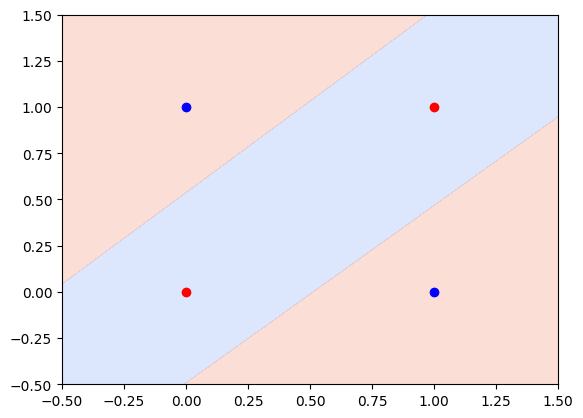

In [43]:
# --- MLP ---
mlp = ml_tower_slots.MLP([2, 2, 1])

inputs = X.tolist()
outputs = Y.reshape(-1, 1).tolist()

mlp.train_py(inputs, outputs, True, num_iter=20000, alpha=0.1)

ok_mlp = all(
    (mlp.predict_py(x, True)[0] >= 0 and y > 0) or (mlp.predict_py(x, True)[0] < 0 and y < 0)
    for x, y in zip(inputs, Y)
)
print("MLP XOR :", "OK" if ok_mlp else "KO")

# Affichage séparation MLP
zz_mlp = np.array([mlp.predict_py([x,y], True)[0] for x,y in zip(xx.flatten(), yy.flatten())]).reshape(xx.shape)

plt.contourf(xx, yy, zz_mlp, levels=[-1, 0, 1], alpha=0.3, cmap='coolwarm')
plt.scatter(X[0:2, 0], X[0:2, 1], color='blue')
plt.scatter(X[2:4, 0], X[2:4, 1], color='red')
plt.show()

























































































### Cross :
        Linear Model    : KO
        MLP (2, 4, 1)   : OK

In [44]:
X = np.random.random((500, 2)) * 2.0 - 1.0
Y = np.array([1 if abs(p[0]) <= 0.3 or abs(p[1]) <= 0.3 else -1 for p in X])

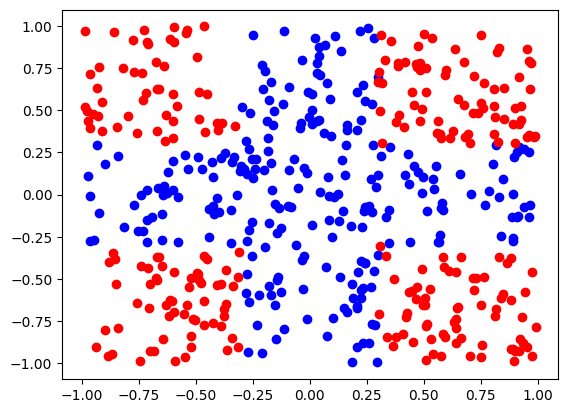

<Figure size 640x480 with 0 Axes>

In [45]:
plt.scatter(np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]] == 1, enumerate(X)))))[:,0], np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]] == 1, enumerate(X)))))[:,1], color='blue')
plt.scatter(np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]] == -1, enumerate(X)))))[:,0], np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]] == -1, enumerate(X)))))[:,1], color='red')
plt.show()
plt.clf()

Perceptron Cross : KO


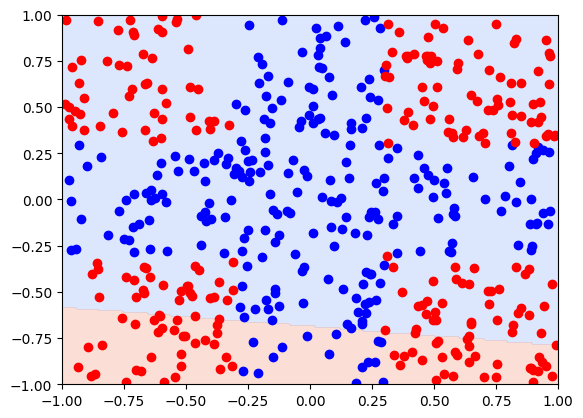

<Figure size 640x480 with 0 Axes>

In [46]:
p = ml_tower_slots.Perceptron(2, 0.1, True)
for _ in range(10000):
    for x, y in zip(X, Y):
        p.train_py(list(x), float(y))

ok_perceptron = all(
    (p.predict_py(list(x)) >= 0 and y > 0) or (p.predict_py(list(x)) < 0 and y < 0)
    for x, y in zip(X, Y)
)
print("Perceptron Cross :", "OK" if ok_perceptron else "KO")

# Affichage frontière Perceptron
grid = np.linspace(-1, 1, 200)
xx, yy = np.meshgrid(grid, grid)
zz = np.array([p.predict_py([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]).reshape(xx.shape)

plt.contourf(xx, yy, zz, levels=[-1, 0, 1], alpha=0.3, cmap='coolwarm')
plt.scatter(
    np.array([p[0] for i, p in enumerate(X) if Y[i] == 1]),
    np.array([p[1] for i, p in enumerate(X) if Y[i] == 1]),
    color='blue'
)
plt.scatter(
    np.array([p[0] for i, p in enumerate(X) if Y[i] == -1]),
    np.array([p[1] for i, p in enumerate(X) if Y[i] == -1]),
    color='red'
)
plt.show()
plt.clf()

MLP Cross : KO


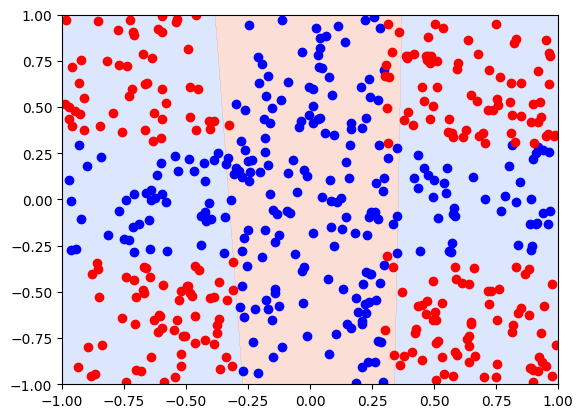

In [47]:
mlp = ml_tower_slots.MLP([2, 4, 1])

inputs = X.tolist()
outputs = Y.reshape(-1, 1).tolist()

mlp.train_py(inputs, outputs, True, num_iter=20000, alpha=0.1)

ok_mlp = all(
    (mlp.predict_py(x, True)[0] >= 0 and y > 0) or (mlp.predict_py(x, True)[0] < 0 and y < 0)
    for x, y in zip(inputs, Y)
)
print("MLP Cross :", "OK" if ok_mlp else "KO")

# Affichage frontière MLP
zz_mlp = np.array([mlp.predict_py([x, y], True)[0] for x, y in zip(xx.flatten(), yy.flatten())]).reshape(xx.shape)

plt.contourf(xx, yy, zz_mlp, levels=[-1, 0, 1], alpha=0.3, cmap='coolwarm')
plt.scatter(
    np.array([p[0] for i, p in enumerate(X) if Y[i] == 1]),
    np.array([p[1] for i, p in enumerate(X) if Y[i] == 1]),
    color='blue'
)
plt.scatter(
    np.array([p[0] for i, p in enumerate(X) if Y[i] == -1]),
    np.array([p[1] for i, p in enumerate(X) if Y[i] == -1]),
    color='red'
)
plt.show()

### Multi Linear 3 classes :
        Linear Model x3 : OK
        MLP (2, 3)      : OK

In [48]:
X = np.random.random((500, 2)) * 2.0 - 1.0
Y = np.array([[1, -1, -1] if -p[0] - p[1] - 0.5 > 0 and p[1] < 0 and p[0] - p[1] - 0.5 < 0 else
              [-1, 1, -1] if -p[0] - p[1] - 0.5 < 0 and p[1] > 0 and p[0] - p[1] - 0.5 < 0 else
              [-1, -1, 1] if -p[0] - p[1] - 0.5 < 0 and p[1] < 0 and p[0] - p[1] - 0.5 > 0 else
              [-1, -1, -1]for p in X])

X = X[[not np.all(arr == [-1, -1, -1]) for arr in Y]]
Y = Y[[not np.all(arr == [-1, -1, -1]) for arr in Y]]

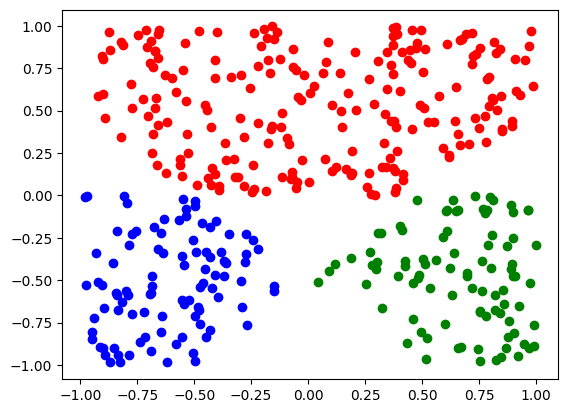

<Figure size 640x480 with 0 Axes>

In [49]:
plt.scatter(np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][0] == 1, enumerate(X)))))[:,0], np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][0] == 1, enumerate(X)))))[:,1], color='blue')
plt.scatter(np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][1] == 1, enumerate(X)))))[:,0], np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][1] == 1, enumerate(X)))))[:,1], color='red')
plt.scatter(np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][2] == 1, enumerate(X)))))[:,0], np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][2] == 1, enumerate(X)))))[:,1], color='green')
plt.show()
plt.clf()

In [50]:
perceptrons = [ml_tower_slots.Perceptron(2, 0.1, True) for _ in range(3)]

# Entraînement multi-perceptrons
for epoch in range(1000):
    for x, y in zip(X, Y):
        for i in range(3):
            perceptrons[i].train_py(list(x), float(y[i]))

# Validation
ok = True
for x, y in zip(X, Y):
    preds = [p.predict_py(list(x)) for p in perceptrons]
    # choisir classe max (sortie positive préférée)
    pred_class = np.argmax(preds)
    true_class = np.argmax(y)
    if pred_class != true_class:
        ok = False
print("Perceptron multi-classes :", "OK" if ok else "KO")



Perceptron multi-classes : OK


In [51]:
# --- MLP multi-sortie ---
mlp = ml_tower_slots.MLP([2, 3])
inputs = X.tolist()
outputs = Y.tolist()
mlp.train_py(inputs, outputs, True, num_iter=20000, alpha=0.1)

ok_mlp = True
for x, y in zip(inputs, outputs):
    preds = mlp.predict_py(x, True)
    pred_class = np.argmax(preds)
    true_class = np.argmax(y)
    if pred_class != true_class:
        ok_mlp = False
print("MLP multi-classes :", "OK" if ok_mlp else "KO")


MLP multi-classes : KO


In [52]:
X = np.random.random((1000, 2)) * 2.0 - 1.0
Y = np.array([[1, -1, -1] if abs(p[0] % 0.5) <= 0.25 and abs(p[1] % 0.5) > 0.25 else [-1, 1, -1] if abs(p[0] % 0.5) > 0.25 and abs(p[1] % 0.5) <= 0.25 else [-1, -1, 1] for p in X])

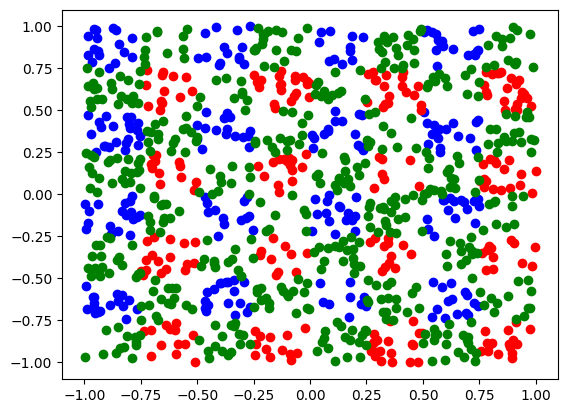

<Figure size 640x480 with 0 Axes>

In [53]:
plt.scatter(np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][0] == 1, enumerate(X)))))[:,0], np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][0] == 1, enumerate(X)))))[:,1], color='blue')
plt.scatter(np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][1] == 1, enumerate(X)))))[:,0], np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][1] == 1, enumerate(X)))))[:,1], color='red')
plt.scatter(np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][2] == 1, enumerate(X)))))[:,0], np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][2] == 1, enumerate(X)))))[:,1], color='green')
plt.show()
plt.clf()

## Régression

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import ml_tower_slots

ModuleNotFoundError: No module named 'ml_tower_slots'

### Linear Simple 2D :
        Linear Model : OK
        MLP (1, 1)   : OK

In [ ]:
X = np.array([
      [1],
      [2]
])
Y = np.array([
      2,
      3
])

In [ ]:
plt.scatter(X,Y)
plt.show()
plt.clf()

In [ ]:
# Perceptron en mode régression (classification=False)
p = ml_tower_slots.Perceptron(1, 0.01, False)
for _ in range(3000):
    for x, y in zip(X, Y):
        p.train_py(list(x), float(y))

# Validation simple : erreur moyenne
mse_p = np.mean([(p.predict_py(list(x)) - y) ** 2 for x, y in zip(X, Y)])
print(f"Perceptron MSE : {mse_p:.4f}")

# Seuil arbitraire à 0.1 (à adapter selon problème)
ok = mse_p < 0.1
print("Résultat Perceptron :", "OK" if ok else "KO")

# MLP en régression
mlp = ml_tower_slots.MLP([1, 1])
for _ in range(3000):
    mlp.train_py(X.tolist(), Y.reshape(-1,1).tolist(), False, num_iter=1, alpha=0.01)

mse_mlp = np.mean([(mlp.predict_py(list(x), False)[0] - y) ** 2 for x, y in zip(X, Y)])
print(f"MLP MSE : {mse_mlp:.4f}")

ok_mlp = mse_mlp < 0.1
print("Résultat MLP :", "OK" if ok_mlp else "KO")

# Préparer la grille pour afficher les prédictions
grid = np.linspace(0.5, 2.5, 100)
zz_p = np.array([p.predict_py([x]) for x in grid])
zz_mlp = np.array([mlp.predict_py([x], False)[0] for x in grid])

# Affichage
plt.scatter(X, Y, label="Données", color='black')
plt.plot(grid, zz_p, label="Perceptron", color='blue')
plt.plot(grid, zz_mlp, label="MLP", color='red')
plt.show()

### Non Linear Simple 2D :
        Linear Model    : OK
        MLP (1, ?, 1)   : OK

In [ ]:
X = np.array([
      [1],
      [2],
      [3]
])
Y = np.array([
      2,
      3,
      2.5
])

In [ ]:
plt.scatter(X,Y)
plt.show()
plt.clf()

In [ ]:
# Perceptron pour régression (classification=False)
p = ml_tower_slots.Perceptron(1, 0.01, False)
for _ in range(10000):
    for x, y in zip(X, Y):
        p.train_py(list(x), float(y))

# Prédiction Perceptron sur un intervalle
grid = np.linspace(0.5, 3.5, 100)
preds_p = np.array([p.predict_py([x]) for x in grid])

plt.scatter(X, Y, label="Données")
plt.plot(grid, preds_p, label="Perceptron", color="orange")
plt.title("Régression Perceptron")
plt.legend()
plt.show()
plt.clf()

# MLP pour régression
mlp = ml_tower_slots.MLP([1, 3, 1])
inputs = X.tolist()
outputs = Y.reshape(-1, 1).tolist()

mlp.train_py(inputs, outputs, False, num_iter=3000000, alpha=0.01)

# Prédiction MLP
preds_mlp = np.array([mlp.predict_py([x], False)[0] for x in grid])

plt.scatter(X, Y)
plt.plot(grid, preds_mlp, color="green")
plt.show()
plt.clf()

### Linear Simple 3D :
        Linear Model    : OK
        MLP (2, 1)      : OK

In [ ]:
X = np.array([
      [1, 1],
      [2, 2],
      [3, 1]
])
Y = np.array([
      2,
      3,
      2.5
])

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:,0],X[:,1],Y)
plt.show()
plt.clf()

### Linear Tricky 3D :
        Linear Model    : OK
        MLP (2, 1)      : OK

In [ ]:
X = np.array([
      [1, 1],
      [2, 2],
      [3, 3]
])
Y = np.array([
      1,
      2,
      3
])

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:,0],X[:,1],Y)
plt.show()
plt.clf()

### Non Linear Simple 3D :
        Linear Model       : KO
        MLP (2, 2, 1)      : OK

In [ ]:
X = np.array([
      [1, 0],
      [0, 1],
      [1, 1],
      [0, 0],
])
Y = np.array([
      2,
      1,
      -2,
      -1
])

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:,0],X[:,1],Y)
plt.show()
plt.clf()